# LSTM in Pytorch

In [31]:
#library imports
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import re
import spacy
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt

## Multiclass Text Classification

We are going to predict item ratings based on customer reviews bsed on this dataset from Kaggle:
https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews

In [4]:
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 4.0 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [13]:
#loading the data
emotions = pd.read_csv("data/emotions.csv")
print(emotions.shape)
emotions.head()

(3631, 3)


,text,target,emotion
0,"@user happy bday Ruth, hope you have an amazin...",1,joy
1,Banger sit in 2013 reason why we great doings ...,1,joy
2,Height of irritation when a person makes a hil...,0,anger
3,"#internationaldayofpeace Want peace,prepare fo...",0,anger
4,Oi @user you've absolutely fucking killed me.....,1,joy


In [16]:
#tokenization
tok = spacy.load("en_core_web_sm")
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

In [17]:
#count number of occurences of each word
counts = Counter()
for index, row in emotions.iterrows():
    counts.update(tokenize(row["text"]))

In [19]:
counts.most_common(10)

[(' ', 9190),
 ('user', 2259),
 ('  ', 1927),
 ('i', 1756),
 ('the', 1659),
 ('to', 1326),
 ('a', 1180),
 ('and', 994),
 ('you', 820),
 ('is', 817)]

In [20]:
#deleting infrequent words
print("num_words before:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("num_words after:",len(counts.keys()))

num_words before: 8824
num_words after: 3849


In [21]:
#creating vocabulary
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [23]:
def encode_sentence(text, vocab2index, N=70):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [26]:
emotions["encoded"] = emotions["text"].apply(lambda x: np.array(encode_sentence(x,vocab2index ), dtype=object))
emotions.head()

,text,target,emotion,encoded
0,"@user happy bday Ruth, hope you have an amazin...",1,joy,"[[2, 3, 4, 5, 1, 2, 6, 7, 8, 9, 10, 11, 2, 12,..."
1,Banger sit in 2013 reason why we great doings ...,1,joy,"[[1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1, 22..."
2,Height of irritation when a person makes a hil...,0,anger,"[[26, 27, 28, 29, 30, 31, 32, 30, 33, 1, 34, 3..."
3,"#internationaldayofpeace Want peace,prepare fo...",0,anger,"[[2, 37, 38, 39, 1, 22, 40, 2, 41, 42, 43, 44,..."
4,Oi @user you've absolutely fucking killed me.....,1,joy,"[[1, 2, 3, 7, 46, 47, 48, 49, 50, 15, 51, 52, ..."


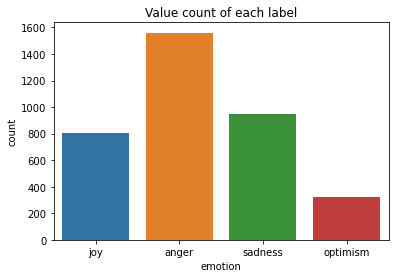

In [32]:
ax = sns.countplot(x="emotion", data=emotions)
ax.set_title("Value count of each label")
plt.show()

In [34]:
X = list(emotions["encoded"])
y = list(emotions["target"])
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

#### Pytorch Dataset

In [35]:
class ReviewsDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx][0].astype(np.int32)), self.y[idx], self.X[idx][1]

In [36]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [37]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [38]:
batch_size = 5000
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

### LSTM with fixed length input

In [39]:
class LSTM_fixed_len(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, l):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [40]:
model_fixed =  LSTM_fixed_len(vocab_size, 50, 50)

In [41]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.513, val loss 1.463, val accuracy 0.428, and val rmse 1.757
train loss 1.296, val loss 1.287, val accuracy 0.428, and val rmse 1.757
train loss 1.273, val loss 1.271, val accuracy 0.428, and val rmse 1.757
train loss 1.268, val loss 1.264, val accuracy 0.428, and val rmse 1.757
train loss 1.265, val loss 1.260, val accuracy 0.428, and val rmse 1.757
train loss 1.264, val loss 1.262, val accuracy 0.428, and val rmse 1.757


In [42]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.305, val loss 1.258, val accuracy 0.428, and val rmse 1.757
train loss 1.267, val loss 1.260, val accuracy 0.428, and val rmse 1.757
train loss 1.268, val loss 1.258, val accuracy 0.428, and val rmse 1.757
train loss 1.266, val loss 1.267, val accuracy 0.428, and val rmse 1.757
train loss 1.263, val loss 1.258, val accuracy 0.428, and val rmse 1.757
train loss 1.264, val loss 1.258, val accuracy 0.428, and val rmse 1.757


In [43]:
train_model(model_fixed, epochs=30, lr=0.01)

train loss 1.277, val loss 1.258, val accuracy 0.428, and val rmse 1.757
train loss 1.271, val loss 1.265, val accuracy 0.428, and val rmse 1.757
train loss 1.267, val loss 1.259, val accuracy 0.428, and val rmse 1.757
train loss 1.264, val loss 1.264, val accuracy 0.428, and val rmse 1.757
train loss 1.263, val loss 1.258, val accuracy 0.428, and val rmse 1.757
train loss 1.263, val loss 1.259, val accuracy 0.428, and val rmse 1.757


### LSTM with variable length input

In [44]:
class LSTM_variable_input(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.dropout = nn.Dropout(0.3)
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 5)
        
    def forward(self, x, s):
        x = self.embeddings(x)
        x = self.dropout(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [45]:
model = LSTM_variable_input(vocab_size, 50, 50)

In [46]:
train_model(model, epochs=30, lr=0.1)

train loss 1.456, val loss 1.898, val accuracy 0.224, and val rmse 2.138
train loss 1.146, val loss 1.218, val accuracy 0.488, and val rmse 1.554
train loss 0.842, val loss 1.211, val accuracy 0.546, and val rmse 1.519
train loss 0.625, val loss 1.368, val accuracy 0.568, and val rmse 1.459
train loss 0.483, val loss 1.465, val accuracy 0.583, and val rmse 1.408
train loss 0.393, val loss 1.604, val accuracy 0.565, and val rmse 1.426


In [47]:
train_model(model, epochs=30, lr=0.05)

train loss 0.528, val loss 1.675, val accuracy 0.576, and val rmse 1.403
train loss 0.318, val loss 1.693, val accuracy 0.590, and val rmse 1.419
train loss 0.264, val loss 1.697, val accuracy 0.575, and val rmse 1.394
train loss 0.230, val loss 1.783, val accuracy 0.575, and val rmse 1.392
train loss 0.218, val loss 1.875, val accuracy 0.583, and val rmse 1.369
train loss 0.175, val loss 1.954, val accuracy 0.572, and val rmse 1.389


In [48]:
train_model(model, epochs=30, lr=0.05)

train loss 0.214, val loss 2.064, val accuracy 0.587, and val rmse 1.348
train loss 0.178, val loss 2.146, val accuracy 0.558, and val rmse 1.454
train loss 0.161, val loss 2.193, val accuracy 0.587, and val rmse 1.372
train loss 0.132, val loss 2.204, val accuracy 0.591, and val rmse 1.405
train loss 0.130, val loss 2.248, val accuracy 0.596, and val rmse 1.352
train loss 0.114, val loss 2.348, val accuracy 0.571, and val rmse 1.423
